In [1]:
from tensorflow.python.eager import backprop
from tensorflow.python.keras.engine import data_adapter
from tensorflow.python.keras import backend as K
#from tensorflow.python.keras.mixed_precision.experimental import loss_scale_optimizer as lso
from tensorflow.python.distribute import parameter_server_strategy
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pickle


import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
plt.style.use('seaborn-whitegrid')

#To run project notebooks in subfolders as from root folder
import sys
sys.path.append('../../')

###Import self-written library
from featexlib import Debug as dbug
from featexlib import *

#for autorealoading the submodules
%load_ext autoreload
%autoreload 2

x_load.shape = (10, 256, 768, 3) , y_load.shape = (10, 256, 768, 7)
Amount of classes: 7


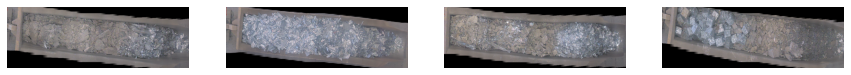

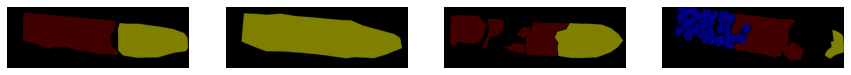

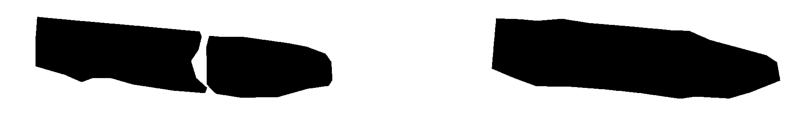

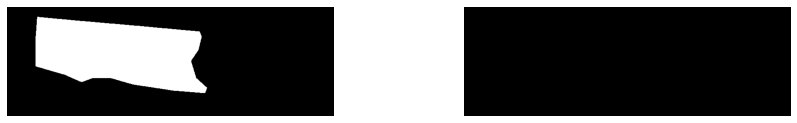

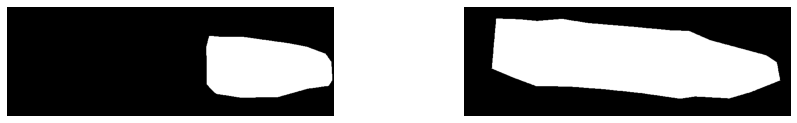

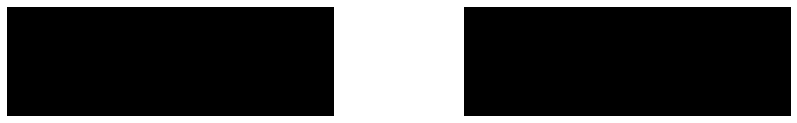

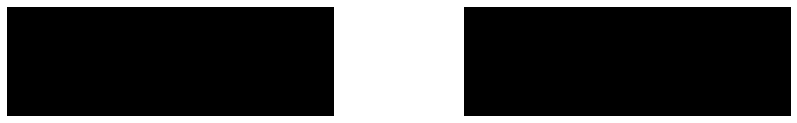

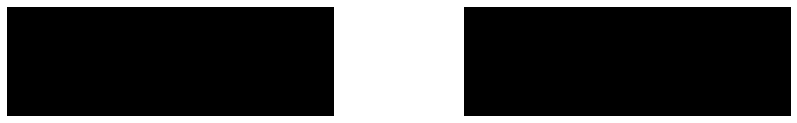

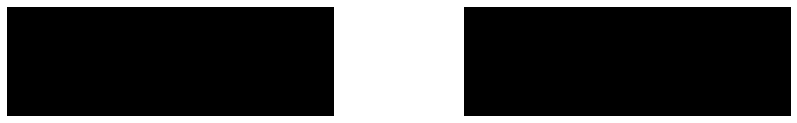

In [28]:
###ACTIVE CELL####
###Load data
###Testing that data has been saved and can be loaded

x_load, y_load, y_load_raw = Image_generator.load_data(save_dir = "../../Data/scrapid/training_data/", name="scrapid_7c_768x256_10_1")

print("===================================")

#Show some result images
print('x_load.shape =',x_load.shape,',', 'y_load.shape =',y_load.shape)
print('Amount of classes:',  y_load.shape[-1])
dbug.show_images_list(x_load[:4,...,[2,1,0]], col_number = 4)
dbug.show_images_list(y_load_raw[:4,...,[2,1,0]], col_number = 4)
for c in range(y_load.shape[-1]):
    dbug.show_images_list(y_load[:2,...,c], col_number = 2) 
    


In [29]:
###ACTIVE CELL####
###Split data to test and train
n_offset = 0
n_train = 8
n_test = 2
pic_h = x_load.shape[1]
pic_w = x_load.shape[2]
pic_ch = x_load.shape[3] if len(x_load.shape)>3 else 1
num_classes = y_load.shape[-1]

###Get X train and test
x_train, x_test = x_load[n_offset:n_offset+n_train], x_load[n_offset+n_train:n_offset+n_train+n_test]
y_train, y_test = y_load[n_offset:n_offset+n_train], y_load[n_offset+n_train:n_offset+n_train+n_test]
y_train_raw, y_test_raw = y_load_raw[n_offset:n_offset+n_train], y_load_raw[n_offset+n_train:n_offset+n_train+n_test]

print("===============Data is ready====================")
print("Shape X,Y for train:",x_train.shape,y_train.shape)
print("Shape X,Y for test: ",x_test.shape,y_test.shape)

###Clean memory
del x_load, y_load, y_load_raw

===============Data is ready====================
Shape X,Y for train: (8, 256, 768, 3) (8, 256, 768, 7)
Shape X,Y for test:  (2, 256, 768, 3) (2, 256, 768, 7)


In [9]:
###ACTIVE CELL####
###Reshape and then rescale dataset
scaler = StandardScaler()
x_train_sc = scaler.fit_transform(x_train.reshape(x_train.shape[0],-1))
x_test_sc  = scaler.transform(x_test.reshape(x_test.shape[0],-1))

if y_train.max() > 1:
    y_train_sc = y_train/255
    y_test_sc  = y_test/255
else:
    y_train_sc = y_train
    y_test_sc  = y_test
        
print(x_train_sc.shape, y_train_sc.shape, x_test_sc.shape, y_test_sc.shape)

(8, 589824) (8, 256, 768, 7) (2, 589824) (2, 256, 768, 7)


In [10]:
###ACTIVE CELL####
x_test_sc.mean()


0.6479255218017026

In [11]:
###ACTIVE CELL####
###Export scaler
pickle.dump(scaler, open('../../models/scalers/scrapid_7c_850x256_10_1_unet_scaler_v1.pkl','wb'))

###Load scaler
#scaler = pickle.load(open('models/scalers/scrapid_7c_850x256_10_1_unet_scaler_v1.pkl','rb'))

In [ ]:
###Load scaler
##NOT USED
scaler = pickle.load(open('models/scalers/scrapid_7c_850x256_10_1_unet_scaler_v1.pkl','rb'))
x_test_sc  = scaler.transform(x_test.reshape(x_test.shape[0],-1))
x_test_sc.mean()

In [12]:
###ACTIVE CELL####
###Prepare for training: check labels dimension (-1), change X to float32 instead of float64
ys = y_train_sc.astype('float32').reshape(-1,pic_h,pic_w,num_classes)
xs = x_train_sc.astype('float32').reshape(-1,pic_h,pic_w,pic_ch)
#ys_one_hot = tf.one_hot(ys, num_classes) ###not used

ys_test = y_test_sc.reshape(-1,pic_h,pic_w,num_classes)
xs_test = x_test_sc.astype('float32').reshape(-1,pic_h,pic_w,pic_ch)

###Clear memory
#del x_train, y_train, y_test, x_test
print(xs.shape, ys.shape, xs_test.shape, ys_test.shape)

(8, 256, 768, 3) (8, 256, 768, 7) (2, 256, 768, 3) (2, 256, 768, 7)


In [13]:
###ACTIVE CELL####
#Model
#Prepare model transfer-learned VGG16

K.clear_session()
def unet(pretrained_weights = None,input_size = (256,768,3), full_train=False):
    VGG16_weight = "../../models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
    VGG16 = tf.keras.applications.VGG16(include_top=False, weights=VGG16_weight, input_shape=input_size)
    last_layer = VGG16.output
    for layer in VGG16.layers:
        if layer.name in ['block1_conv1']:
            set_trainable = True
        if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
            layer.trainable = full_train
            
    model_ = tf.keras.layers.Conv2DTranspose(256,(3,3),strides=(2, 2), padding='same')(last_layer)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)    
    
    concat_1 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block5_conv3").output])
    
    model_ = tf.keras.layers.Conv2D(512,(3,3),strides=(1, 1), padding='same')(concat_1)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2DTranspose(512,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_) 
    
    concat_2 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block4_conv3").output])
    
    model_ = tf.keras.layers.Conv2D(512,(3,3),strides=(1, 1), padding='same')(concat_2)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2DTranspose(512,(3,3),strides=(2, 2), padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_) 
    
    concat_3 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block3_conv3").output])
    
    model_ = tf.keras.layers.Conv2D(256,(3,3),strides=(1, 1), padding='same')(concat_3)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2DTranspose(256,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_) 
    
    concat_4 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block2_conv2").output])
    
    model_ = tf.keras.layers.Conv2D(128,(3,3),strides=(1, 1), padding='same')(concat_4)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2DTranspose(128,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_) 
    
    concat_5 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block1_conv2").output])
    
    model_ = tf.keras.layers.Conv2D(64,(3,3),strides=(1, 1), padding='same')(concat_5)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2D(32,(3,3),strides=(1, 1), padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2D(7,(3,3),strides=(1, 1),padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.Model(VGG16.input,model_)
    
    model_.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'categorical_hinge', metrics = ['accuracy'])
    #model_.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    if(pretrained_weights):
        model_.load_weights(pretrained_weights)
    
    return model_

In [11]:
model = unet()

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 768, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 768, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 768, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 384, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [30]:
model.fit(xs, ys, batch_size=10, epochs=20)

Epoch 1/20
1/1 [==============================] - 47s 47s/step - loss: 0.2404 - accuracy: 0.9337
Epoch 2/20
1/1 [==============================] - 46s 46s/step - loss: 0.2425 - accuracy: 0.9305
Epoch 3/20
1/1 [==============================] - 46s 46s/step - loss: 0.2426 - accuracy: 0.9323
Epoch 4/20
1/1 [==============================] - 47s 47s/step - loss: 0.2087 - accuracy: 0.9428
Epoch 5/20
1/1 [==============================] - 48s 48s/step - loss: 0.2062 - accuracy: 0.9387
Epoch 6/20
1/1 [==============================] - 49s 49s/step - loss: 0.2052 - accuracy: 0.9386
Epoch 7/20
1/1 [==============================] - 54s 54s/step - loss: 0.1924 - accuracy: 0.9466
Epoch 8/20
1/1 [==============================] - 47s 47s/step - loss: 0.1911 - accuracy: 0.9474
Epoch 9/20
1/1 [==============================] - 46s 46s/step - loss: 0.1887 - accuracy: 0.9474
Epoch 10/20
1/1 [==============================] - 47s 47s/step - loss: 0.1834 - accuracy: 0.9486
Epoch 11/20
1/1 [============

In [29]:
#fit model for big data

checkpointer = tf.keras.callbacks.ModelCheckpoint('../../models/scrapid_7c_850x256_10_1_unet_vgg16.h5', verbose=1,mode='auto', monitor='loss',save_best_only=True)

def GenerateInputs(X,y):
    for i in range(len(X)):
        X_input = X[i].reshape(-1,pic_h,pic_w,pic_ch)
        y_input = y[i].reshape(-1,pic_h,pic_w,num_classes)
        yield (X_input,y_input)
        
model.fit_generator(GenerateInputs(xs,ys),epochs=2,verbose=1,callbacks=[checkpointer],
                     steps_per_epoch=8,shuffle=True)

Epoch 1/2
8/8 [==============================] - 61s 8s/step - loss: 0.8636 - accuracy: 0.6763

Epoch 00001: loss improved from inf to 0.86362, saving model to ../../models/scrapid_7c_850x256_10_1_unet_vgg16.h5
Epoch 2/2
8/8 [==============================] - 0s 1ms/step - loss: 0.8636 - accuracy: 0.6763

Epoch 00002: loss did not improve from 0.86362


In [44]:
###Save model 1 after training
model.save_weights('../../models/scrapid_7c_850x256_10_1_unet_acc0956')

In [14]:
###Continue model training
model = unet()
model.load_weights('../../models/scrapid_7c_850x256_10_1_unet_acc0956')
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 768, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 768, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 768, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 384, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

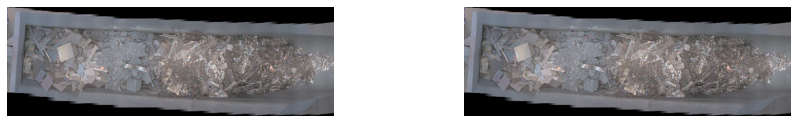

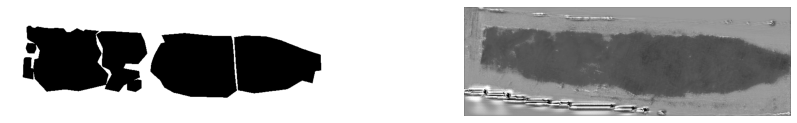

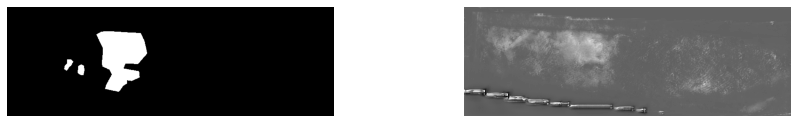

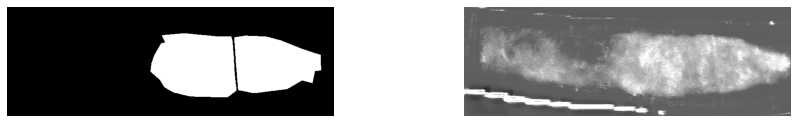

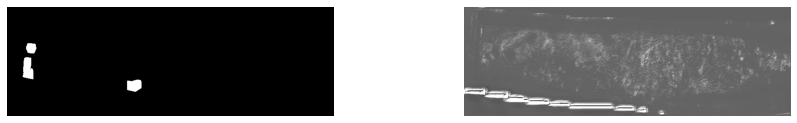

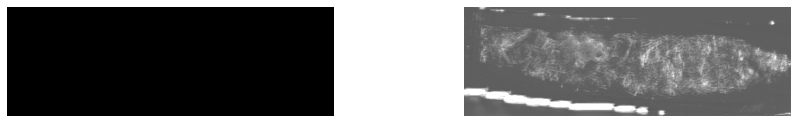

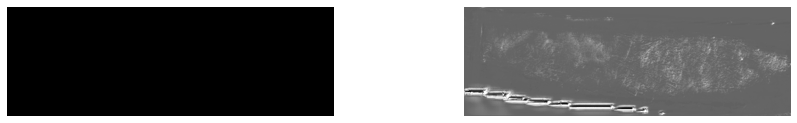

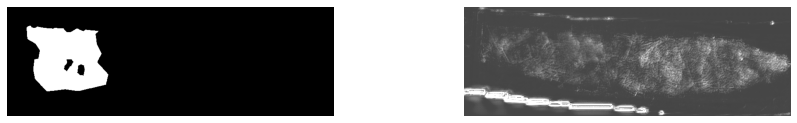

In [17]:
def show_predict(x,x_orig,y_orig, number):
    y_pred = model(x[number].reshape(-1,pic_h,pic_w,pic_ch)).numpy()
    y_pred = (np.clip(((y_pred - y_pred.mean() + y_pred.std())/y_pred.std())*127, 0,255)).astype('int16')
    dbug.show_images_list([x_orig[number],x_orig[number]], col_number = 2)
    for c in range(y_orig.shape[-1]):
        dbug.show_images_list([y_orig[number,...,c].reshape(pic_h,pic_w,1), y_pred[...,c].reshape(pic_h,pic_w,1)], col_number = 2) 


numm = 1
show_predict(xs_test,x_test,y_test, numm)

In [32]:
####ACTIVE CELL#####
#Helpful functions for showing result

#List of codes, should be the same as in training
list_of_codes = [
    0, #Black
    64, #Dark red
    32896, #Yellow
    8388608, #Blue
    32768, #Green
    192, #Red
    8388736, #Violet
]

#Help function to get RGB codes from DEC
def get_rgb_from_codes(inp):
    return np.array([[i//65536,(i - 65536*(i//65536))//256, i - 65536*(i//65536) - 256*((i - 65536*(i//65536))//256)] for i in inp]).astype(np.uint8)

list_of_colors = get_rgb_from_codes(list_of_codes)


def show_predict_multi(x,x_orig,y_orig, number):
    
    y_pred = model(x[number].reshape(-1,pic_h,pic_w,pic_ch)).numpy()
    
    res_r = np.argmax(y_pred, axis=3)
    res_g = np.copy(res_r)
    res_b = np.copy(res_r)

    for c in range(y_pred.shape[-1]):
        res_r[res_r == c] =  list_of_colors[c,0]
        res_g[res_g == c] =  list_of_colors[c,1]
        res_b[res_b == c] =  list_of_colors[c,2]

    res = np.concatenate([res_r[...,None],res_g[...,None],res_b[...,None]], axis=3)
    
    
    for c in range(res.shape[0]):
        dbug.show_images_list([x_orig[number][c,...][...,[2,1,0]],res[c,...][...,[2,1,0]],y_orig[number][c,...][...,[2,1,0]]],col_number = 3)
        #dbug.show_images_list(res[c,...],col_number = 3)
        #dbug.show_images_list(y_orig[number][c,...],col_number = 3)

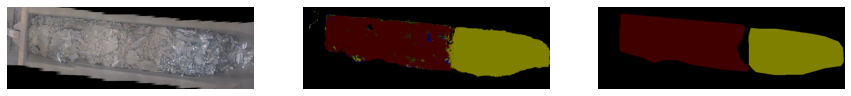

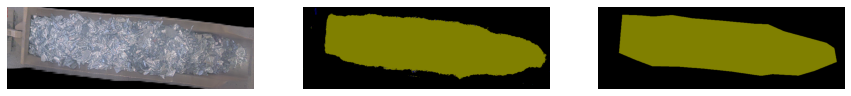

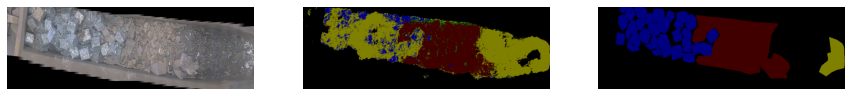

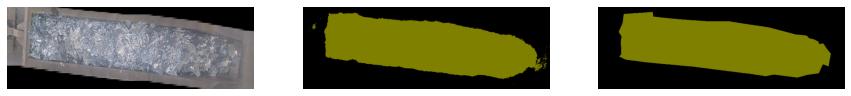

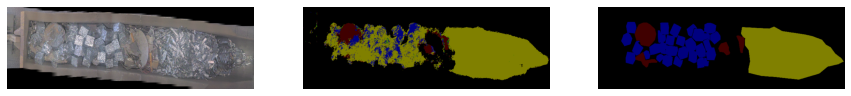

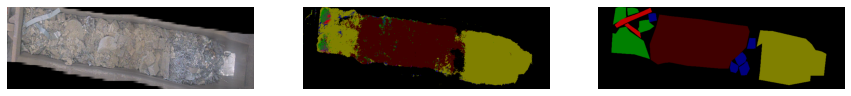

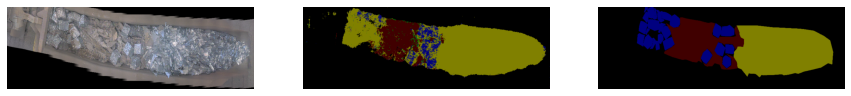

In [34]:
####ACTIVE CELL###########
####Show result in train dataset

num = [0,1,3,4,5,6,7]
show_predict_multi(xs,x_train,y_train_raw,num)        

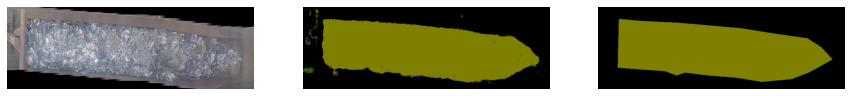

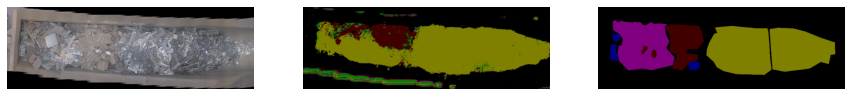

In [35]:
####ACTIVE CELL###########
####Show result in test dataset

num = [0,1]
show_predict_multi(xs_test,x_test,y_test_raw,num)   